<h1>Importation des packages et des fonctions</h1>

<p>Parmi les packages importés on retrouve :<br>
   <ul>
       <li>fonctionsUtiles : package qui sert pour l'augmentation des données</li>
       <li>matplotlib, numpy : visualisation et manipulation de données</li>
       <li>cv2 : pour resize les images et les adapter à l'input du modèle</li> 
       <li>sklearn : pour la fonction train_test_split</li>
       <li>Tensorflow, keras : framework pour deeplearning</li>
   </ul>
   <b>Attention :</b> Sur ce notebook, on utilise Tensorflow Hub pour récupérer les modèles pré-entrainés et non l'importation depuis Keras.
</p>

In [1]:
import sys
sys.path.append('../')

from fonctionsUtiles import functions as f
from fonctionsUtiles import architecture

import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

import keras
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.python.keras.models import Sequential, load_model
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout

__init__


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


ImportError: No module named 'tensorflow_hub'

<h1>Chargement de toutes les données</h1>

<p>
    On récupère les données d'entrainement d'un projet (Axionaut) qui a gagné une des précédentes courses IronCar.
</p>

In [ ]:
# Récupérer les données du circuit Axionable
X_axio = np.load('../Datasets/Classification/axionable_data/X_train_axio.npy')
Y_axio = np.load('../Datasets/Classification/axionable_data/Y_train_axio.npy')
print('Axionable data Loaded. Shape = ', np.shape(X_axio))

# Récupérer les données d'entrainement du circuit IronCar
# Nouveau circuit - Double chicane
X_chicane = np.load('../Datasets/Classification/ironcar_data/new_track/x_chicane.npy')
Y_chicane = np.load('../Datasets/Classification/ironcar_data/new_track/y_chicane.npy')
print('Ironcar new track chicane Loaded. Shape = ', np.shape(X_chicane))

# Ancien circuit - Dataset équilibré
X_iron = np.load('../Datasets/Classification/ironcar_data/old_track/balanced_iron_X.npy')
Y_iron = np.load('../Datasets/Classification/ironcar_data/old_track/balanced_iron_Y.npy')
print('Ironcar old track data Loaded. Shape = ', np.shape(X_iron))

<h1>Resizing des données</h1>

<p>
    Pour l'approche Transfer Learning, il faut faire attention à l'input du modèle pré-entrainé que l'on utilise. Dans notre cas, MobileNetV2 admet en input des images de taille 224 x 224. Il faut donc resize les images qui sont de format 90 x 250
</p>

In [3]:
def resizing(array):
    masterX = list()
    for arr in array:
        masterX.append(cv2.resize(arr, (224,224)))
    return np.array(masterX)

X_axio_resized = resizing(X_axio)
X_chicane_resized = resizing(X_chicane)
X_iron_resized = resizing(X_iron)

print('Axionable data new size. Shape = ', np.shape(X_axio_resized))
print('Ironcar new track chicane new size. Shape = ', np.shape(X_chicane_resized))
print('Ironcar old track data new size. Shape = ', np.shape(X_iron_resized))

Axionable data new size. Shape =  (26449, 224, 224, 3)
Ironcar new track chicane new size. Shape =  (1519, 224, 224, 3)
Ironcar old track data new size. Shape =  (16028, 224, 224, 3)


<h1>Séparation des données en Train, Test et Validation</h1>

<p>
    On sépare le jeu de données en Training set, Validation set et Testing set selon les proportions suivantes :<br>
    <ul>
        <li>X_test = 20 % du set Xfinal_resized</li>
        <li>X_train = 80 % des données restantes de Xfinal_resized (soit 64 % du jeu total de données)</li>
        <li>X_val = 20 % des données restantes de Xfinal_resized (soit 16 % du jeu total de données)</li>
    </ul>
</p>

In [4]:
# Dictionnaire qui stock quelques variables importantes
args = {"augmentation": True,
        "train_split": 0.8,
        "val_split":0.2,
        "test_split":0.2,
        "early_stop":True,
       "patience":2}

<p>Avant d'effectuer la sépration du jeu de données en Train, Validation et Test, on concatène tous les vecteurs</p>

In [5]:
# Concatenation de toutes les données chargées
X = np.concatenate((X_axio_resized, X_chicane_resized, X_iron_resized))
Y = np.concatenate((Y_axio, Y_chicane, Y_iron))
print('All data loaded and concatenated. Shape = ', np.shape(X))

# Suppression des variables tmp qui contiennent les images
del X_axio, Y_axio, X_chicane, Y_chicane, X_iron, Y_iron, X_axio_resized, X_chicane_resized, X_iron_resized

All data loaded and concatenated. Shape =  (43996, 224, 224, 3)


In [6]:
# Réparatition du jeu de données en train test 80 - 20 %
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=12)

In [7]:
# Répartition du jeu d'entrainement en jeu d'entrainement et en jeu de validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=12)

In [8]:
print('All training data loaded and augmented. Shape = ', np.shape(X_train))
print('All validation data loaded and augmented. Shape = ', np.shape(X_val))
print('All testing data loaded and augmented. Shape = ', np.shape(X_test))

All training data loaded and augmented. Shape =  (28156, 224, 224, 3)
All validation data loaded and augmented. Shape =  (7040, 224, 224, 3)
All testing data loaded and augmented. Shape =  (8800, 224, 224, 3)


In [9]:
# Suppression des variables tmp qui contiennent les images
del X,Y

<h1>Augmentation des données</h1>

<p>
    On augmente les données uniquement sur le jeu d'entrainement pour éviter que le jeu de validation et de test ne contiennent des données que le modèle aurait "déjà vu" pendant son entrainement.<br><br>
    On rajoute 10% d'image pour chacun des effets suivant :
    <ul>
        <li>luminosité augmentée</li>
        <li>effet de nuit</li>
        <li>flip horizontal</li>
        <li>ombres aléatoires sur la route</li>
        <li>les quatres transformations précédentes à la chaine</li>
    </ul>
</p>

In [10]:
# Data augmentation du dataset
if args['augmentation']:
    print('Augmenting data... Wait...')
    # Data augmentation 10% de luminosité aléatoire.
    X_bright, Y_bright = f.generate_brightness(X_train, Y_train, proportion=0.1)
    # Data augmentation 10% d'effet de nuit.
    X_night, Y_night = f.generate_night_effect(X_train, Y_train, proportion=0.1)
    # Data augmentation 10% de flip horizontal
    X_flip, Y_flip = f.generate_horizontal_flip(X_train, Y_train, proportion=0.1)
    # Data augmentation 10% d'ombres aléatoires.
    X_shadow, Y_shadow = f.generate_random_shadows(X_train, Y_train, proportion=0.1)
    # Data augmentation 10% de transformation à la chaine (bright + shadows + flip).
    X_chain, Y_chain = f.generate_chained_transformations(X_train, Y_train, proportion=0.1)

    # Concaténation des données générées avec les anciennes
    X_train = np.concatenate((X_train, X_bright, X_night,
                                 X_shadow))

    Y_train = np.concatenate((Y_train, Y_bright, Y_night, 
                                 Y_shadow)).astype('float32')

    print('Train data after augmentation. Shape = ', np.shape(X_train))

  1%|          | 49/7039 [00:00<00:14, 487.69it/s]

Augmenting data... Wait...


100%|██████████| 7039/7039 [00:18<00:00, 377.95it/s]


Axionable data after augmentation. Shape =  (63351, 224, 224, 3)


In [11]:
# Suppression des variables temporaires qui contiennent les images
del X_bright, Y_bright, X_night, Y_night, X_flip, Y_flip, X_shadow, Y_shadow, X_chain, Y_chain

<h1>Hyperparamètres</h1>

<p>
    On définit les hyperparamètres pour le modèle, ici le nombre de classes pour la classification (<code>num_classes</code>) la taille de l'input (<code>IMAGE_RES</code>), la taille des batch pour l'entrainement (<code>BATCH_SIZE</code>), et le nombre d'epoch pour la phase d'entrainement (<code>epochs</code>).
</p>

In [12]:
num_classes = 5
IMAGE_RES = 224
BATCH_SIZE = 200
epochs = 8


<h1>Définition du modèle</h1>

<p>
    On utilise le modèle MobileNetV2 comme base préentrainée. Les poids chargés sont ceux qui résultent de l'entrainement sur "ImageNet". On rajoute ensuite quelques layers personnalisés pour adapter le réseau à notre problème.
</p>

In [13]:
# Initialisation du modèle : on télécharge le modèle MobilNetV2 en ne prenant pas en compte la dernière couche car
# elle ne correspond pas à notre problème. Comme précisé au début, on utilise Tensorflow hub
my_new_model = Sequential()
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

# Transfer learning ==> on fige les poids pour ne pas les réentrainer
feature_extractor.trainable = False

# On rajoute la dernière couche de classification qui sera entrainée
my_new_model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

# On vérifie que le modèle est défini correctement
my_new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 2,439,109
Trainable params: 181,125
Non-trainable params: 2,257,984
_________________________________________________________________


In [14]:
# On définit la fonction d'optimisation du modèle
my_new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

<h1>Schéma du modèle</h1>

In [ ]:
# from keras.utils import plot_model
# plot_model(my_new_model, to_file='model.png')

# Cela ne fonctionne pas avec les modèles issus de Tensorflow Hub

<h1>Entrainement du modèle</h1>

<p>
    On effectue l'entrainement selon les jeux de données d'entrainement et de validation définis plus haut dans le notebook. On utilise également les hyper paramètres définis auparavant.
</p>

In [ ]:
min_delta=.0005

#checkpoint pour sauver le modèle après chaque epoch
save_best = keras.callbacks.ModelCheckpoint(model_name, 
                                            monitor='val_loss', 
                                            verbose=1, 
                                            save_best_only=True, 
                                            mode='min')

#arrêt de l'entrainement dans le cas où la validation loss ne diminue plus
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                           min_delta=min_delta, 
                                           patience=args['patience'], 
                                           verbose=1, 
                                           mode='auto')
callbacks_list = [save_best]

if args['early_stop']:
    callbacks_list.append(early_stop)

hist = my_new_model.fit(
                X_train, 
                Y_train,
                epochs = epochs,
                batch_size=BATCH_SIZE, 
                verbose=1, 
                validation_data=(X_val, Y_val),
                callbacks=callbacks_list,
                shuffle=True)

my_new_model.save('../Models/TransferMobileNetV2_8Epochs_class_hub.h5')

Train on 63351 samples, validate on 7040 samples
Epoch 1/8
63351/63351 [==============================] - 1036s 16ms/sample - loss: 0.7431 - acc: 0.7421 - val_loss: 0.3673 - val_acc: 0.9097
Epoch 2/8
63351/63351 [==============================] - 1036s 16ms/sample - loss: 0.4987 - acc: 0.8425 - val_loss: 0.3406 - val_acc: 0.9115
Epoch 3/8
63351/63351 [==============================] - 1064s 17ms/sample - loss: 0.4164 - acc: 0.8733 - val_loss: 0.2939 - val_acc: 0.9298
Epoch 4/8
63351/63351 [==============================] - 1011s 16ms/sample - loss: 0.3612 - acc: 0.8928 - val_loss: 0.2691 - val_acc: 0.9381
Epoch 5/8
63351/63351 [==============================] - 1049s 17ms/sample - loss: 0.3247 - acc: 0.9070 - val_loss: 0.2614 - val_acc: 0.9391
Epoch 6/8
63351/63351 [==============================] - 1068s 17ms/sample - loss: 0.2947 - acc: 0.9185 - val_loss: 0.2588 - val_acc: 0.9405
Epoch 7/8
56800/63351 [=========================>....] - ETA: 1:41 - loss: 0.2764 - acc: 0.9246

<h1>Temps de prédiction pour une image</h1>

<p>
    La cellule suivante utilise une image du jeu de test et calcule le temps qu'il faut pour effectuer la prédiction.
</p>

In [18]:
import time
start=time.time()
for i in range(1):
    my_new_model.predict(X_test[i-1:i])

print(time.time()-start)

0.0033974647521972656


<h1>Evaluation du modèle</h1>

<p>La cellule suivante permet de tester le modèle selon un jeu de test qu'il n'a jamais vu auparavant. On peut voir si le modèle a overfit les données ou non.</p>

In [19]:
my_new_model.evaluate(X_test, Y_test)

8800/8800 [==============================] - 62s 7ms/sample - loss: 0.2542 - acc: 0.9415


[0.254181880002672, 0.9414773]

<h1>Divers tracés</h1>

<h3>Evolution de l'accuracy train et val en fonction du nombre d'epoch</h3>

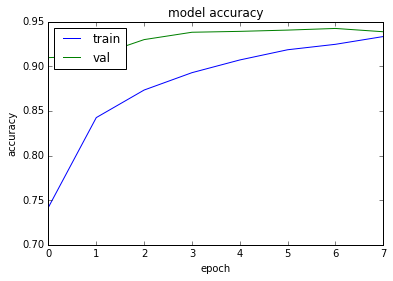

In [20]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

<h3>Evolution de la loss train et val en fonction du nombre d'epoch</h3>

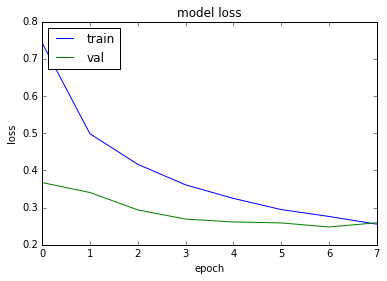

In [21]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

<h1>Chargement du modèle</h1>

<p>Les deux prochaines cellules servent à charger un modèle sauvegardé puis à l'évaluer sur un jeu de test. Attention cependant il faut redéfinir le jeux de test avant d'exécuter la deuxième cellule</p>

In [ ]:
my_new_model = tf.keras.models.load_model('../Models/Julien/TransferMobileNetV2_8Epochs_class_hub.h5',custom_objects={'KerasLayer':hub.KerasLayer})
my_new_model.summary()

In [ ]:
my_new_model.evaluate(X_test, Y_test)

<p>
    La cellule suivante permet d'évaluer l'erreur du modèle en degrés parmi les catégories suivantes : forte gauche, gauche, tout droit, droite, forte droite.
</p>

In [ ]:
# On effectue la prédiction sur le jeu de test
Y_pred = my_new_model.predict(X_test)

# On effectue un petit traitement pour avoir un format des prédictions compatible avec la fonction utilisée ensuite
Y_pred1=[0]*len(Y_pred)
for i in range(len(Y_pred)):
    Y_pred1[i]=Y_pred[i][0]
Y_pred1=np.array(Y_pred1)

# On appelle la fonction error_regression qui calcule l'erreur en degrés
error.error_classification(Y_test,Y_pred1)